## Global

### Imports

In [2]:
# Import das bibliotecas base:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [3]:
#Import dos arquivos csv
pilotos = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/pilotos.csv')
piloto_classificacoes = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/piloto_classificacoes.csv')
corridas = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/corridas.csv')
sprint_resultados = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/sprint_resultados.csv')
circuitos = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/circuitos.csv') 
tempo_por_volta = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/tempo_por_volta.csv') 
parada_boxes = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/parada_boxes.csv')
qualificacao = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/qualificacao.csv') 
resultados = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/resultados.csv')
construtores = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/construtores.csv')
construtor_classificacoes = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/construtor_classificacoes.csv')
construtor_resultados = pd.read_csv('./Tratamento_Limpeza_Dataset/bases_br/construtor_resultados.csv')

## Machine Learning

#### Previsão de proximas 10 melhores tempo por volta em certo circuito

##### Correção coluna corrida_id

In [4]:
resultados = resultados.rename(columns={'corridas_id': 'corrida_id'})
resultados = resultados.dropna(subset=['volta_rapida_tempo'])
resultados['volta_rapida_tempo'] = resultados['volta_rapida_tempo'].str.split(':').apply(lambda x: int(x[0])*60 + float(x[1]))

In [5]:
merged_data = pd.merge(corridas, resultados, how='inner', on='corrida_id')
merged_data = merged_data[merged_data['circuito_id'] == 1]

##### Código

Epoch 1/50
39/39 [==============================] - 2s 7ms/step - loss: 0.0058
Epoch 2/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0043
Epoch 3/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 4/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 5/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 6/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0040
Epoch 7/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 8/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 9/50
39/39 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 10/50
39/39 [==============================] - 0s 8ms/step - loss: 0.0038
Epoch 11/50
39/39 [==============================] - 0s 8ms/step - loss: 0.0040
Epoch 12/50
39/39 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 13/50
39/39 [==============================

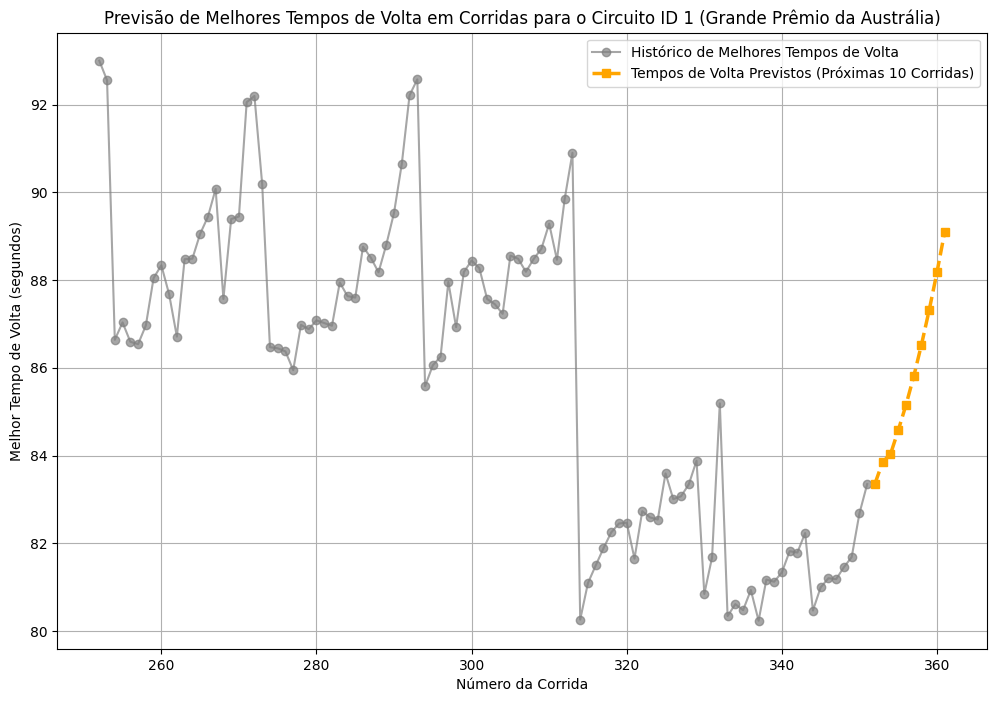

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Mesclar corridas com resultados
merged_data = pd.merge(corridas, resultados, how='inner', on='corrida_id')
merged_data = merged_data[merged_data['circuito_id'] == 1]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data['volta_rapida_tempo'].values.reshape(-1, 1))

# Preparar dados para o modelo
x_train, y_train = [], []
for i in range(40, len(scaled_data)):
    x_train.append(scaled_data[i-40:i, 0])
    y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape para atender aos padrões do TensorFlow
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Criar modelo RNN
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo
model.fit(x_train, y_train, epochs=50, batch_size=8)

# Prever tempos de volta futuros (próximas 10 corridas)
future_races = 10
x_future = scaled_data[-40:].reshape(1, -1, 1)
predictions = []

for _ in range(future_races):
    prediction = model.predict(x_future)
    predictions.append(prediction[0, 0])  # Ajuste para extrair o valor escalar da previsão
    x_future = np.append(x_future[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Desescalar as previsões
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Criar índice de corridas para plotagem da previsão
start_index = len(merged_data) - 100  # Mostrar apenas as últimas 100 corridas
end_index = len(merged_data)
race_index = np.arange(start=start_index, stop=end_index)
future_race_index = np.arange(start=end_index, stop=end_index + future_races)


# Plotar resultados com mais ênfase na previsão
plt.figure(figsize=(12, 8))
plt.plot(race_index, merged_data['volta_rapida_tempo'].values[start_index:end_index], label='Histórico de Melhores Tempos de Volta', marker='o', linestyle='-', color='gray', alpha=0.7)
plt.plot(future_race_index, predictions, label='Tempos de Volta Previstos (Próximas 10 Corridas)', linestyle='dashed', marker='s', color='orange', linewidth=2.5)
plt.title('Previsão de Melhores Tempos de Volta em Corridas para o Circuito ID 1 (Grande Prêmio da Austrália)')
plt.xlabel('Número da Corrida')
plt.ylabel('Melhor Tempo de Volta (segundos)')
plt.legend()
plt.grid(True)
plt.show()


#### Prevê a proxima melhor corrida em um certo circuito e certo piloto

Epoch 1/25
1/1 [==============================] - 2s 2s/step - loss: 0.1061
Epoch 2/25
1/1 [==============================] - 0s 8ms/step - loss: 0.0346
Epoch 3/25
1/1 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 4/25
1/1 [==============================] - 0s 9ms/step - loss: 0.0171
Epoch 5/25
1/1 [==============================] - 0s 9ms/step - loss: 0.0203
Epoch 6/25
1/1 [==============================] - 0s 9ms/step - loss: 0.0067
Epoch 7/25
1/1 [==============================] - 0s 17ms/step - loss: 1.2181e-04
Epoch 8/25
1/1 [==============================] - 0s 12ms/step - loss: 0.0020
Epoch 9/25
1/1 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 10/25
1/1 [==============================] - 0s 9ms/step - loss: 0.0090
Epoch 11/25
1/1 [==============================] - 0s 8ms/step - loss: 0.0090
Epoch 12/25
1/1 [==============================] - 0s 9ms/step - loss: 0.0068
Epoch 13/25
1/1 [==============================] - 0s 9ms/step - lo

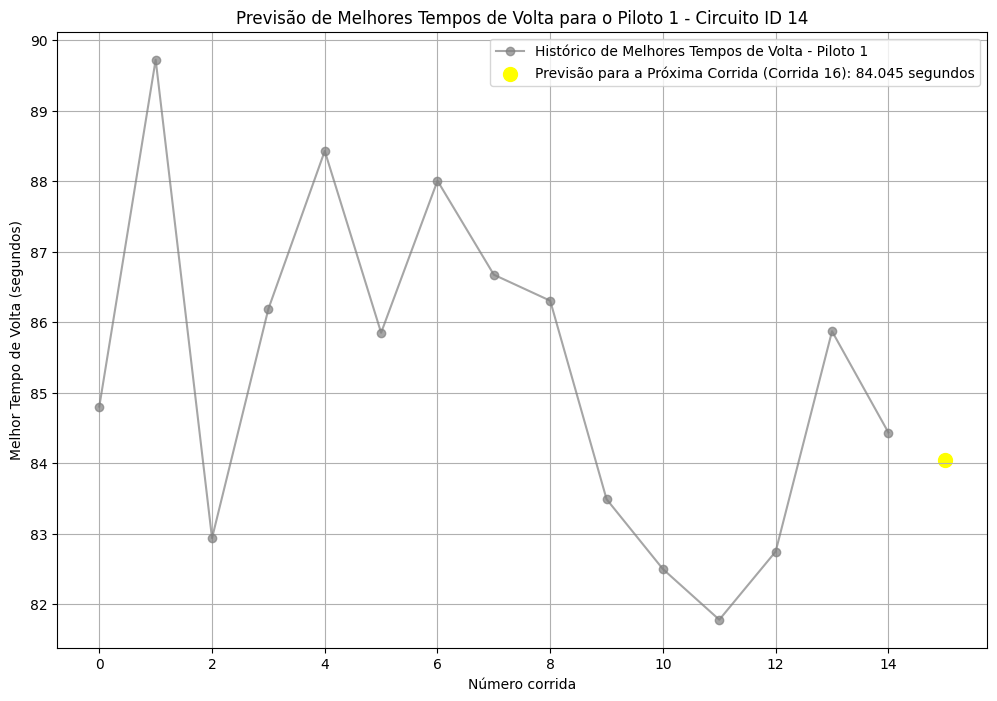

Previsão para a Próxima Corrida (Corrida 16): 84.045 segundos
Tempo Real da Última Corrida: 84.434 segundos
Porcentagem de Erro: 0.46%


In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Suponha que você tenha um ID de piloto específico
piloto_id = 1  # Substitua pelo ID do piloto desejado

# Filtrar resultados para um piloto específico
resultados_piloto = resultados[resultados['piloto_id'] == piloto_id]

# Mesclar corridas com resultados
merged_data = pd.merge(corridas, resultados_piloto, how='inner', on='corrida_id')
merged_data = merged_data[merged_data['circuito_id'] == 14]

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(merged_data['volta_rapida_tempo'].values.reshape(-1, 1))

# Verificar se há dados suficientes para treinar o modelo
if len(scaled_data) <= 2:
    print("Não há dados suficientes para treinar o modelo.")
else:
    # Definir o número de amostras de treinamento
    time_steps = min(40, len(scaled_data) - 1)

    # Preparar dados para o modelo
    x_train, y_train = [], []
    for i in range(time_steps, len(scaled_data)):
        x_train.append(scaled_data[i - time_steps:i, 0])
        y_train.append(scaled_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape para atender aos padrões do TensorFlow
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    # Criar modelo RNN
    model = Sequential()
    model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(units=150, return_sequences=False))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Treinar o modelo com mais épocas
    model.fit(x_train, y_train, epochs=25, batch_size=8)

    # Verificar se há dados suficientes para prever a próxima corrida
    if len(scaled_data) > time_steps:
        # Prever o tempo de volta para a próxima corrida
        x_future = scaled_data[-time_steps:].reshape(1, -1, 1)
        prediction = model.predict(x_future)

        # Desescalar a previsão
        prediction = scaler.inverse_transform(prediction.reshape(-1, 1))[0, 0]

        # Plotar resultados com ênfase na previsão
        plt.figure(figsize=(12, 8))
        plt.plot(merged_data['volta_rapida_tempo'].values, label=f'Histórico de Melhores Tempos de Volta - Piloto {piloto_id}', marker='o', linestyle='-', color='gray', alpha=0.7)
        plt.scatter(len(merged_data), prediction, label=f'Previsão para a Próxima Corrida (Corrida {len(merged_data) + 1}): {prediction:.3f} segundos', color='yellow', s=100)
        plt.title(f'Previsão de Melhores Tempos de Volta para o Piloto {piloto_id} - Circuito ID 14')
        plt.xlabel('Número corrida')
        plt.ylabel('Melhor Tempo de Volta (segundos)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Mostrar as previsões
        print(f"Previsão para a Próxima Corrida (Corrida {len(merged_data) + 1}): {prediction:.3f} segundos")

        # Avaliação da Precisão
        real_data_index = len(merged_data) - 1
        real_data = merged_data['volta_rapida_tempo'].values[real_data_index]
        accuracy = 100 - np.abs(prediction - real_data) / real_data * 100

        print(f"Tempo Real da Última Corrida: {real_data:.3f} segundos")
        print(f"Porcentagem de Erro: {100 - accuracy:.2f}%")
    else:
        print("Não há dados suficientes para prever a próxima corrida.")
